Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking
using CmdStan, StanMCMCChain
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df)
mean_weight = mean(df2[:weight])
df2[:weight] = convert(Vector{Float64}, df2[:weight]) .- mean_weight ;

Define the Stan language model

In [5]:
weightsmodel = "
data {
 int < lower = 1 > N; // Sample size
 vector[N] height; // Predictor
 vector[N] weight; // Outcome
}

parameters {
 real alpha; // Intercept
 real beta; // Slope (regression coefficients)
 real < lower = 0 > sigma; // Error SD
}

model {
 height ~ normal(alpha + weight * beta , sigma);
}

generated quantities {
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [6]:
stanmodel = Stanmodel(name="weights", monitors = ["alpha", "beta", "sigma"],model=weightsmodel,
  output_format=:mcmcchain);
# Input data for cmdstan
heightsdata = Dict("N" => length(df2[:height]), "height" => df2[:height], "weight" => df2[:weight]);


File /Users/rob/.julia/dev/StatisticalRethinking/scripts/04/tmp/weights.stan will be updated.



Sample using cmdstan

In [7]:
rc, chn, cnames = stan(stanmodel, heightsdata, ProjDir, diagnostics=false,
  CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)


Inference for Stan model: weights_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.20, 0.19, 0.23, 0.23) seconds, 0.85 seconds total
Sampling took (0.30, 0.33, 0.28, 0.24) seconds, 1.1 seconds total

                Mean     MCSE  StdDev    5%   50%   95%    N_Eff  N_Eff/s    R_hat
lp__            -747  2.6e-02     1.2  -750  -747  -746  2.2e+03  2.0e+03  1.0e+00
accept_stat__   0.91  1.4e-03   0.100  0.71  0.95   1.0  4.9e+03  4.3e+03  1.0e+00
stepsize__      0.80  2.4e-02   0.033  0.74  0.81  0.84  2.0e+00  1.8e+00  2.4e+13
treedepth__      2.5  1.9e-02     1.0   1.0   2.0   5.0  3.0e+03  2.7e+03  1.0e+00
n_leapfrog__      10  4.2e-01      25   3.0   3.0    35  3.5e+03  3.1e+03  1.0e+00
divergent__     0.00      nan    0.00  0.00  0.00  0.00      nan      nan      nan
energy__         749  4.0e-02     1.7   747   748   752  1.8e+03  1.6e+03  1.0e+00
alpha            155  4.6e-03    0.27   154   155   155  

Compare with a previous result

In [8]:
clip_38s_output = "

Samples were drawn using hmc with nuts.
For each parameter, N_Eff is a crude measure of effective sample size,
and R_hat is the potential scale reduction factor on split chains (at
convergence, R_hat=1).

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
          Mean         SD       Naive SE       MCSE     ESS
alpha 113.82267275 1.89871177 0.0300212691 0.053895503 1000
 beta   0.90629952 0.04155225 0.0006569987 0.001184630 1000
sigma   5.10334279 0.19755211 0.0031235731 0.004830464 1000

Quantiles:
          2.5%       25.0%       50.0%       75.0%       97.5%
alpha 110.1927000 112.4910000 113.7905000 115.1322500 117.5689750
 beta   0.8257932   0.8775302   0.9069425   0.9357115   0.9862574
sigma   4.7308260   4.9644050   5.0958800   5.2331875   5.5133417

";

Plot the density of posterior draws

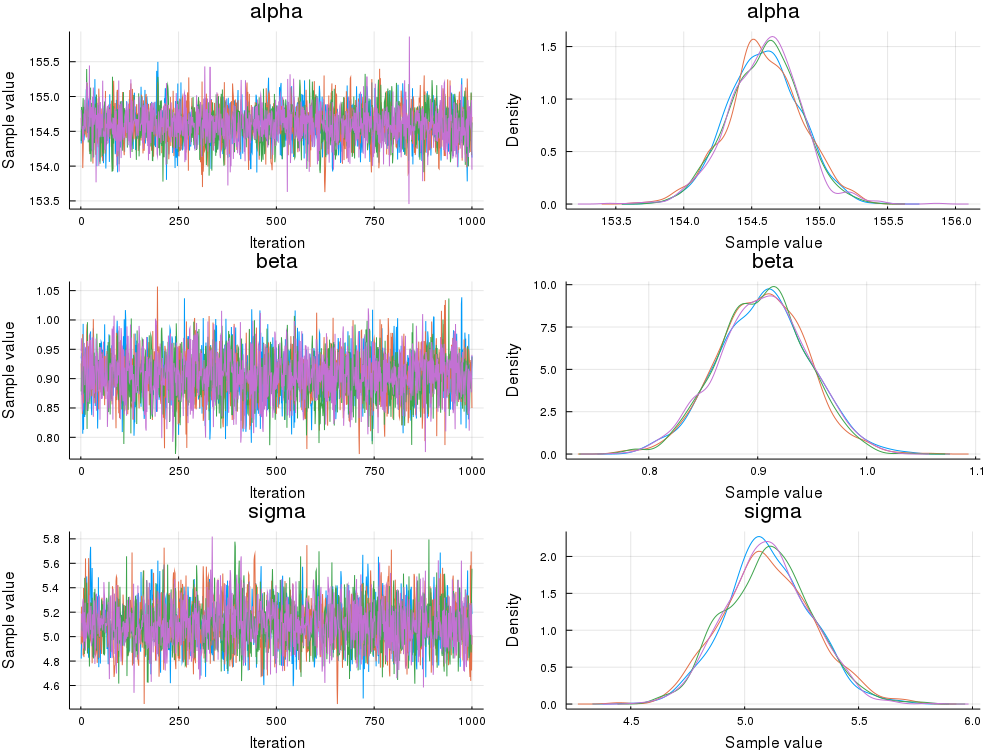

In [9]:
plot(chn)

Plot regression line using means and observations

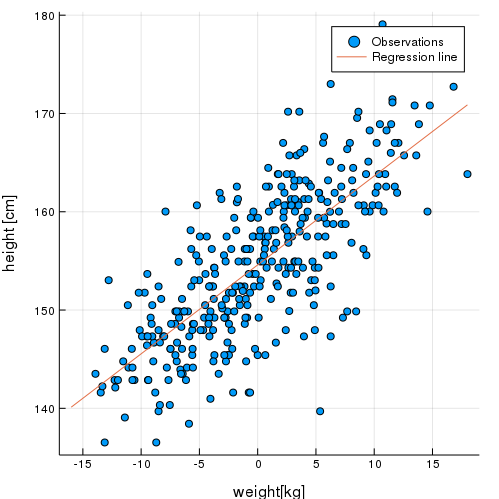

In [10]:
scatter(df2[:weight], df2[:height], lab="Observations",
  ylab="height [cm]", xlab="weight[kg]")
xi = -16.0:0.1:18.0
rws, vars, chns = size(chn[:, 1, :])
alpha_vals = convert(Vector{Float64}, reshape(chn.value[:, 1, :], (rws*chns)))
beta_vals = convert(Vector{Float64}, reshape(chn.value[:, 2, :], (rws*chns)))
yi = mean(alpha_vals) .+ mean(beta_vals)*xi
plot!(xi, yi, lab="Regression line")

End of `clip_43s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*